In [1]:
from typing import Tuple
from IPython.display import Image as Im
from PIL import Image
from sklearn.cluster import KMeans
import numpy as np
import cv2
from scipy.spatial import Delaunay
from ultralytics import YOLO
from shapely import unary_union
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from scipy.ndimage import label
from src.clustering import (
    height_clustering,
    surface_clustering,
)

from src.regularization import (
    oriented_bounding_box,
    snap_to_grid,
    create_grid_cells,
    fill_grid_cells,
    convert_to_rectangles,
    find_intersections,
    create_grid_lines,
    scale_line,
    tin_grid_cells,
    minimum_rectangle,
    create_grid_lines_from_rect,
)
from src.create_polygons import (
    create_polygons,
    smoothed_mask,
    concat_masks,
    create_height_map,
    create_surface_map,
)
from src.line_extraction import (
    extract_intersection_lines,
    extract_step_lines,
)
from src.tin import (
    create_tin
)
from src.visualisation import (
    visualisation,
    vis_heatmap_and_mask,
    vis_heatmap_and_rgb,
    visualisation_lines,
    create_approximate_vis,
    all_visualisation,
    vis_3d_house,
)

from src.modified_contours import (
    apply_canny_to_mask,
    apply_canny,
    thin_contours_skeletonization,
    thin_contours,
)

### Материалы

Не забыть про то, что существует библиотека abspy https://github.com/chenzhaiyu/abspy

Библиотека на cpp https://github.com/tudelft3d/City3D

Что-то на питоне https://github.com/chrise96/3D_building_reconstruction

Еще одна статья про регуляризацию полигонов зданий https://www.mdpi.com/2220-9964/12/12/469

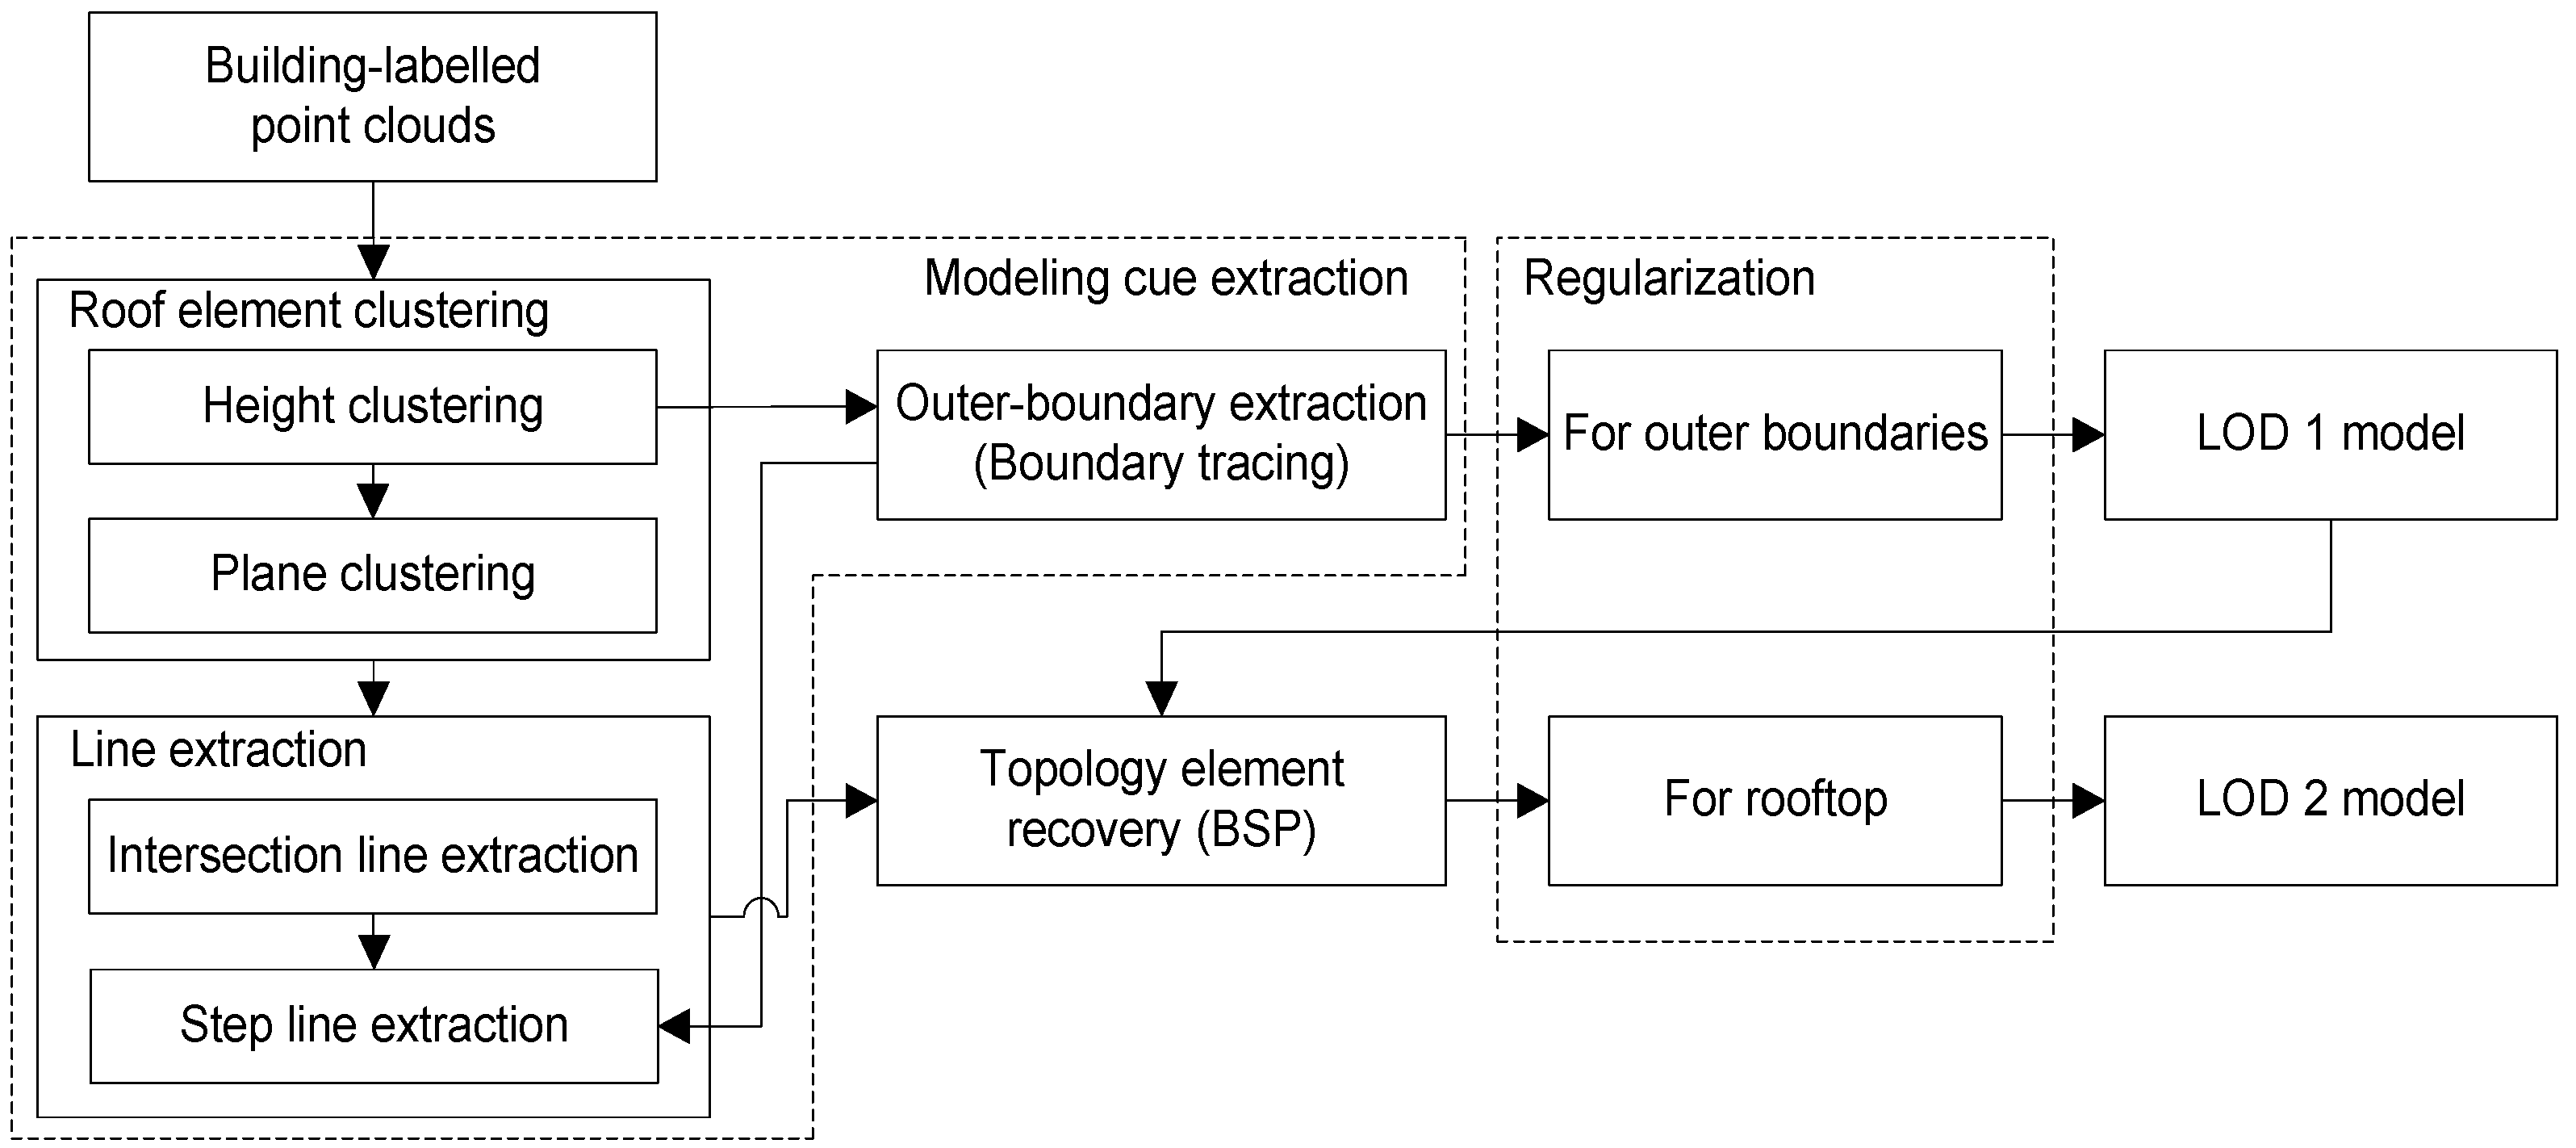

In [2]:
Im(filename='../images/sensors-17-00621-g001.png', width=1000)

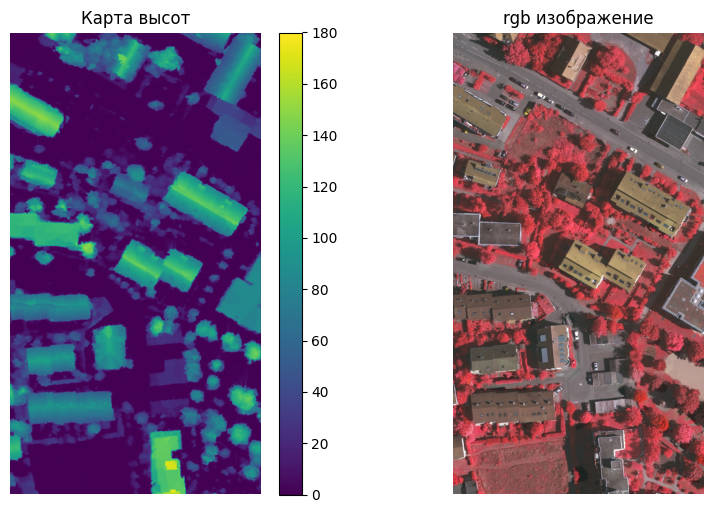

In [3]:
vai: str = '../../../shared_data/datasets/Vaihingen/train/NDSM/area34.tif'
vai_rgb: str = '../../../shared_data/datasets/Vaihingen/train/RGB/area34.tif'
image = Image.open(vai_rgb)
vis_heatmap_and_rgb(vai, vai_rgb)

## Instance mask + Canny + find_contours

In [431]:
heatmap = Image.open(vai)
image = Image.open(vai_rgb)
model = YOLO('../../../shared_data/users/avlasov/vaihingen.pt')
result = model(image)


0: 1024x576 28 buildingss, 20.9ms
Speed: 3.5ms preprocess, 20.9ms inference, 1.9ms postprocess per image at shape (1, 3, 1024, 576)


In [554]:
# crop = slice(874, None), slice(300, 450)
# num = 7
crop = slice(400, 600), slice(240, 440)
num = 0
# crop = slice(None, 250), slice(330, None)
# num = 10

(np.float64(-0.5), np.float64(199.5), np.float64(199.5), np.float64(-0.5))

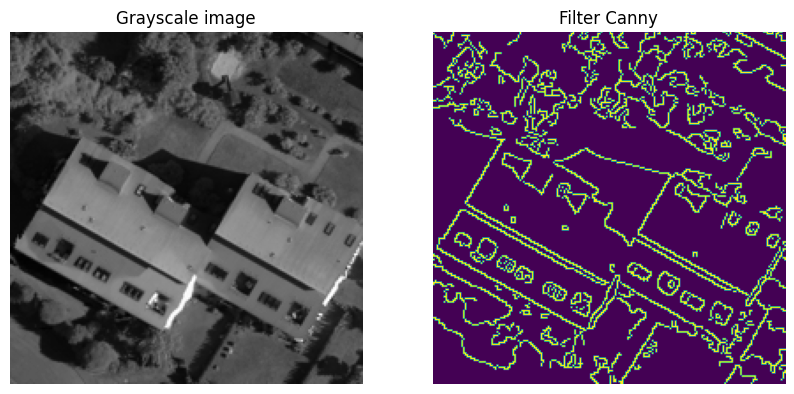

In [555]:
image = Image.open("../../../shared_data/datasets/Vaihingen/train/RGB/area34.tif")
heatmap = Image.open('../../../shared_data/datasets/Vaihingen/train/NDSM/area34.tif')
instance_mask = np.asarray(result[0].masks.data[num].cpu()[crop])
heatmap = heatmap.resize((576, 1024))
heatmap_array = np.array(heatmap)[crop]
image = image.resize((576, 1024))
img_array = np.array(image.convert('L'))[crop]
edges = cv2.Canny(img_array, 100, 200)

_, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(img_array, cmap='gray')
axes[0].set(title='Grayscale image')
axes[0].axis('off')
axes[1].imshow(edges)
axes[1].set(title='Filter Canny')
axes[1].axis('off')

In [556]:
cropped_image = np.array(image)[crop]
edges = apply_canny_to_mask(cropped_image, np.asarray(instance_mask).astype(np.uint8))
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
closed_edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
# closed_edges = cv2.morphologyEx(closed_edges, cv2.MORPH_GRADIENT, kernel)
thin_edges = thin_contours_skeletonization(closed_edges)

In [557]:
from skimage.morphology import skeletonize
def thin_contours_skeletonization(binary_image: np.ndarray) -> np.ndarray:
    # Применение тонкой окантовки: превращаем изображение в двоичное (0 и 1)
    # skimage.skeletonize ожидает 0 и 1, поэтому преобразуем в тип bool
    skeleton = skeletonize(binary_image.astype(np.bool))
    # Преобразуем результат обратно в тип uint8 (0 или 255)
    return (skeleton * 255).astype(np.uint8)

def apply_canny(image: np.ndarray) -> np.ndarray:
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY).astype(np.uint8)
    blurred = cv2.GaussianBlur(gray_image, (5, 5), 0)
    otsu_thresh, _ = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return cv2.Canny(blurred, otsu_thresh * 0.5, otsu_thresh)

# Функция применения Canny к области, указанной маской
def apply_canny_to_mask(image: np.ndarray, mask: np.ndarray) -> np.ndarray:
    # Применяем маску на изображение, чтобы извлечь только интересующую нас часть
    masked_image = cv2.bitwise_and(image, image, mask=mask)
    
    # Преобразуем изображение в оттенки серого (grayscale)
    gray_image = cv2.cvtColor(masked_image, cv2.COLOR_RGB2GRAY)
    
    # Применяем размытие (GaussianBlur) перед Canny для уменьшения шума
    blurred = cv2.GaussianBlur(gray_image, (5, 5), 0)
    
    # Применяем фильтр Canny для выявления краев
    edges = cv2.Canny(blurred, 100, 300)  # Параметры могут быть настроены
    
    return edges

def thin_contours(edges: np.ndarray) -> np.ndarray:
    # Применяем эрозию, чтобы сделать контуры тонкими (шириной в 1 пиксель)
    kernel = np.ones((3, 3), np.uint8)  # 3x3 ядро для эрозии
    thinned = cv2.erode(edges, kernel, iterations=1)  # Применяем эрозию
    return thinned

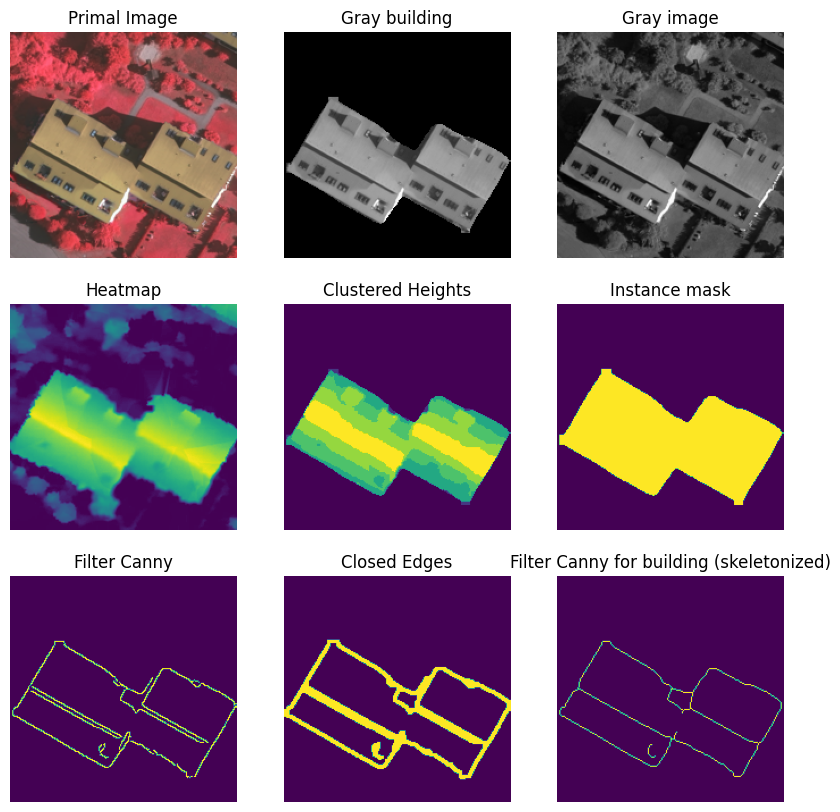

In [ ]:
cropped_image = np.array(image)[crop]
edges = apply_canny_to_mask(cropped_image, np.asarray(instance_mask).astype(np.uint8))

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
closed_edges = cv2.morphologyEx(edges, cv2.MORPH_GRADIENT, kernel)
closed_edges = cv2.morphologyEx(closed_edges, cv2.MORPH_CLOSE, kernel)

thin_edges = thin_contours_skeletonization(closed_edges)
mask = np.expand_dims(instance_mask.astype(np.float32), axis=-1) * cropped_image.astype(np.float32)
mask_edges = apply_canny(mask)
gray_image = cv2.cvtColor(cropped_image, cv2.COLOR_RGB2GRAY)
gray_mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
clustered_heights_building = height_clustering(heatmap_array, instance_mask)
clustered_heights_building[clustered_heights_building == 17] = 0

_, axes = plt.subplots(3, 3, figsize=(10, 10))
axes[0][0].imshow(np.array(image)[crop])
axes[0][0].set(title='Primal Image')
axes[0][0].axis('off')
axes[0][1].imshow(gray_mask, cmap='gray')
axes[0][1].set(title='Gray building')
axes[0][1].axis('off')
axes[0][2].imshow(gray_image, cmap='gray')
axes[0][2].set(title='Gray image')
axes[0][2].axis('off')
axes[1][0].imshow(heatmap_array)
axes[1][0].set(title='Heatmap')
axes[1][0].axis('off')
axes[1][1].imshow(clustered_heights_building)
axes[1][1].set(title='Clustered Heights')
axes[1][1].axis('off')
axes[1][2].imshow(instance_mask)
axes[1][2].set(title='Instance mask')
axes[1][2].axis('off')
axes[2][2].imshow(thin_edges)
axes[2][2].set(title='Filter Canny for building (skeletonized)')
axes[2][2].axis('off')
axes[2][0].imshow(edges)
axes[2][0].set(title='Filter Canny')
axes[2][0].axis('off')
axes[2][1].imshow(closed_edges)
axes[2][1].set(title='Closed Edges')
axes[2][1].axis('off');

In [531]:
surface_mask = label(~thin_edges[:, :])[0]
surface_mask[surface_mask == 0] = 1
print(np.unique(surface_mask))

[1 2 3 4 5]


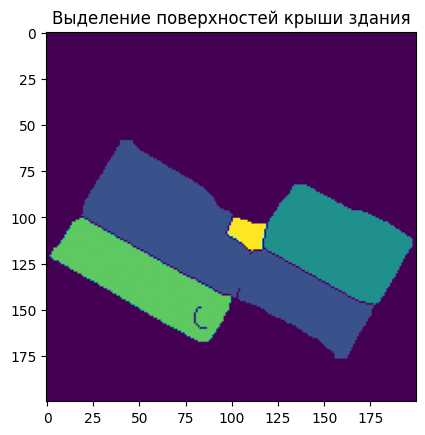

In [489]:
plt.figure()
plt.imshow(surface_mask)
plt.title('Выделение поверхностей крыши здания')
plt.show()

In [490]:
from skimage.measure import find_contours
rng = np.unique(surface_mask)

contour_samples: dict = {}

for instance in rng[1:]:
    contour_samples[int(instance)] = find_contours((surface_mask == instance))

In [496]:
r_contours: dict = {}

for k, v in contour_samples.items():
    try:
        building_polygon = Polygon(contour_samples[k][0])

        resolution: float = 3.0  # Разрешение сетки
        min_rect, rect_coords = minimum_rectangle(building_polygon)

        # Создание сетки внутри bounding box
        h_l, v_l = create_grid_lines_from_rect(rect_coords, resolution)
        # Коэффициент увеличения (например, на 5%)
        scale_factor: float = 1.6
        # Масштабируем линии
        scaled_h_l = np.array([scale_line(line, scale_factor) for line in h_l])
        scaled_v_l = np.array([scale_line(line, scale_factor) for line in v_l])

        intersections = find_intersections(scaled_h_l, scaled_v_l)

        minipolygons = tin_grid_cells(intersections)
        if int(k) == 2:
            example_poly = building_polygon
            example_mini = minipolygons

        r_contours[k] = unary_union(fill_grid_cells(building_polygon, minipolygons))
    except:
        continue

In [497]:
mapp = create_surface_map(r_contours, area_threshold=40)

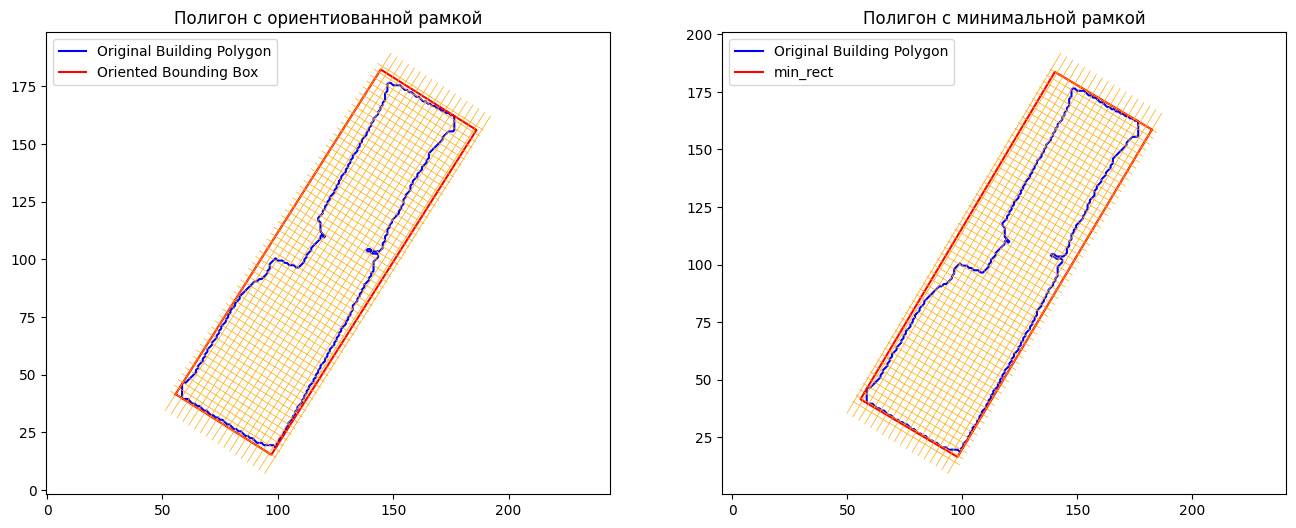

In [498]:
building_polygon = Polygon(contour_samples[2][0])
# Вычисление bounding box
bbox, rotation_matrix, min_point, max_point = oriented_bounding_box(building_polygon)

# Подравнивание полигона с сеткой
resolution: float = 3.0  # Разрешение сетки
min_rect, rect_coords = minimum_rectangle(building_polygon)

# Создание сетки внутри bounding box
h_lines, v_lines = create_grid_lines(min_point, max_point, rotation_matrix, resolution)
h_l, v_l = create_grid_lines_from_rect(rect_coords, resolution)

# Коэффициент увеличения (например, на 5%)
scale_factor: float = 1.1
# Масштабируем линии
scaled_h_lines = np.array([scale_line(line, scale_factor) for line in h_lines])
scaled_v_lines = np.array([scale_line(line, scale_factor) for line in v_lines])
scaled_h_l = np.array([scale_line(line, scale_factor) for line in h_l])
scaled_v_l = np.array([scale_line(line, scale_factor) for line in v_l])

intersections = find_intersections(scaled_h_l, scaled_v_l)

# Выполняем Delaunay триангуляцию
points = intersections
tri = Delaunay(points)

# Создаем список миниполигонов
minipolygons: list = []
for simplex in tri.simplices:
    poly_points = points[simplex]  # Получаем точки треугольника
    polygon = Polygon(poly_points)  # Создаем полигон из точек
    minipolygons.append(polygon)

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# График 1: Полигоны и сетка
axes[0].plot(*building_polygon.exterior.xy, label="Original Building Polygon", color="blue")
axes[0].plot(bbox[:, 0], bbox[:, 1], label="Oriented Bounding Box", color="red")
for line in scaled_h_lines:
    axes[0].plot(line[:, 0], line[:, 1], color="orange", linewidth=0.5)
for line in scaled_v_lines:
    axes[0].plot(line[:, 0], line[:, 1], color="orange", linewidth=0.5)
axes[0].set_title("Полигон с ориентиованной рамкой")
axes[0].axis("equal")
axes[0].legend()

# График 2: Полигоны без сетки
axes[1].plot(*building_polygon.exterior.xy, label="Original Building Polygon", color="blue")
axes[1].plot(*min_rect.exterior.xy, label='min_rect', color='red')
for line in scaled_h_l:
    axes[1].plot(line[:, 0], line[:, 1], color="orange", linewidth=0.5)
for line in scaled_v_l:
    axes[1].plot(line[:, 0], line[:, 1], color="orange", linewidth=0.5)

axes[1].set_title("Полигон с минимальной рамкой")
axes[1].axis("equal")
axes[1].legend()

plt.show()

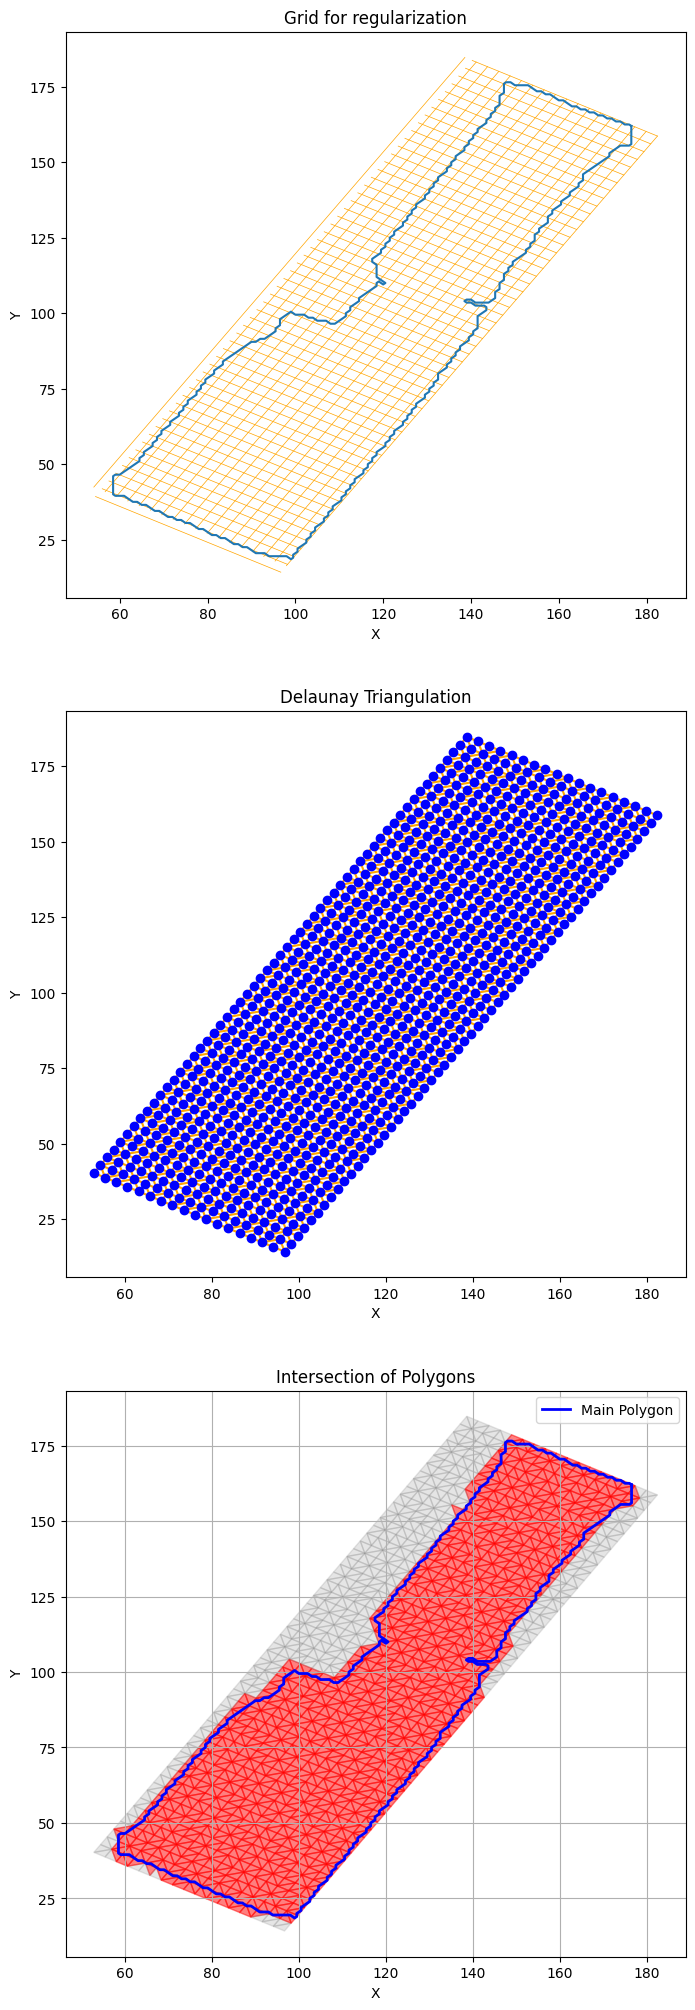

In [499]:
# Визуализация
fig, ax = plt.subplots(3, 1, figsize=(8,25))

for line in h_l:
    ax[0].plot(line[:, 0], line[:, 1], color="orange", linewidth=0.5)
for line in v_l:
    ax[0].plot(line[:, 0], line[:, 1], color="orange", linewidth=0.5)
ax[0].plot(*example_poly.exterior.xy)
ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')
ax[0].set_title('Grid for regularization')
# Отрисовка миниполигонов
ax[1].triplot(points[:, 0], points[:, 1], tri.simplices, color='orange')
ax[1].plot(points[:, 0], points[:, 1], 'o', color='blue')

ax[1].set_xlabel('X')
ax[1].set_ylabel('Y')
ax[1].set_title('Delaunay Triangulation')

for mini_poly in example_mini:
    x, y = mini_poly.exterior.xy
    if example_poly.intersects(mini_poly):  # Проверка на пересечение
        ax[2].fill(x, y, color='red', alpha=0.5)  # Закрашиваем, если пересекаются
    else:
        ax[2].fill(x, y, color='gray', alpha=0.2)  # Иначе полупрозрачный серый

# Отрисовка основного полигона
x, y = example_poly.exterior.xy
ax[2].plot(x, y, color='blue', linewidth=2, label="Main Polygon")

ax[2].set_xlabel('X')
ax[2].set_ylabel('Y')
ax[2].set_title('Intersection of Polygons')
ax[2].legend()
ax[2].grid(True)

plt.show()

In [500]:
contours_dict_new: dict = {}
resolution: float = 5.0
for key, values in contour_samples.items():
    contours: list = []
    for value in values:
        building_polygon = Polygon(value)
        
        # Создание сетки
        grid_cells = create_grid_cells(building_polygon, resolution)

        # Заполнение ячеек сетки
        filled_cells = fill_grid_cells(building_polygon, grid_cells)
        contours.append(unary_union(filled_cells))
    contours_dict_new[key] = contours

In [501]:
np.unique(mapp)

array([          0,           2,           3,           4,           5])

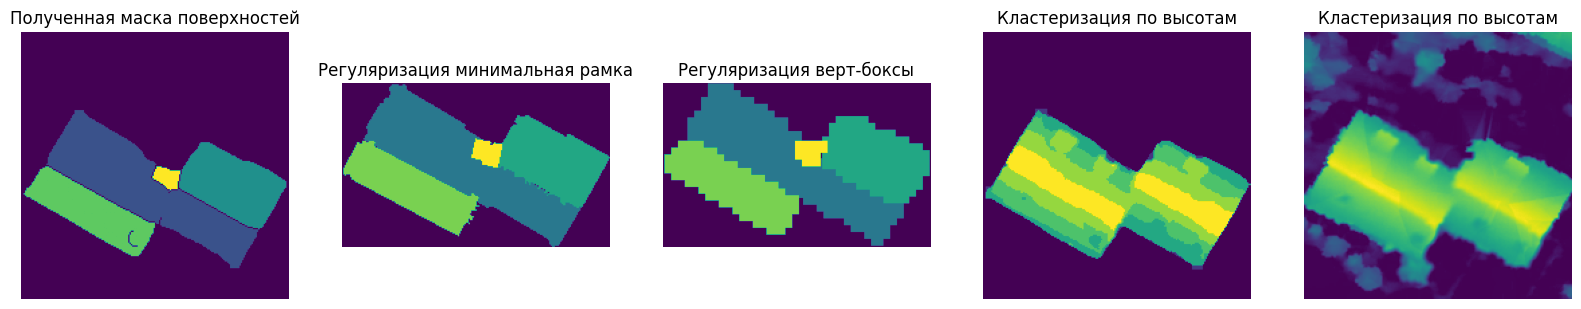

In [502]:
rect_map = create_height_map(contours_dict_new, resolution=1)

x = 114
fig, axs = plt.subplots(1, 5, figsize=(20, 5))
axs[0].imshow(surface_mask)
axs[0].set_title('Полученная маска поверхностей')
axs[0].axis('off')
axs[1].imshow(mapp.T)
axs[1].set_title('Регуляризация минимальная рамка')
axs[1].axis('off')
axs[2].imshow(rect_map.T)
axs[2].set_title('Регуляризация верт-боксы')
axs[2].axis('off')
axs[3].imshow(clustered_heights_building)
axs[3].set_title('Кластеризация по высотам')
axs[3].axis('off')
axs[4].imshow(heatmap_array)
axs[4].set_title('Кластеризация по высотам')
axs[4].axis('off')
plt.show()

In [262]:
exp_height = heatmap_array
exp_surf = mapp.T

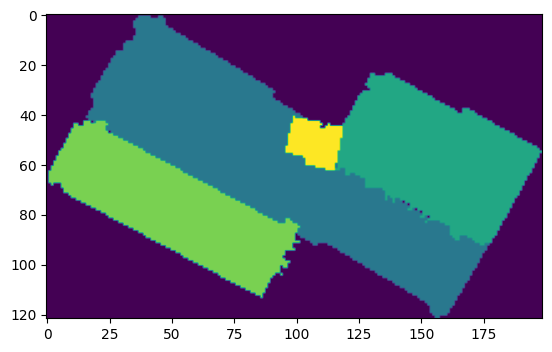

In [263]:
plt.imshow(exp_surf)

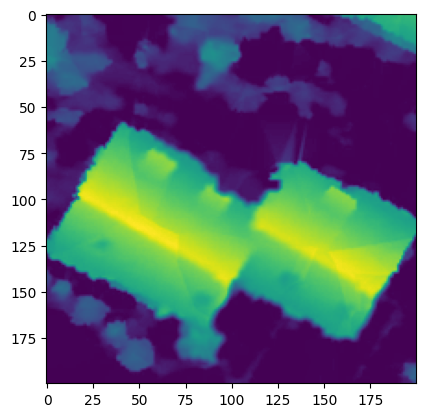

In [264]:
plt.imshow(exp_height)

In [503]:
exp_height.shape, exp_surf.shape

((122, 199), (122, 199))

In [266]:
exp_height, exp_surf = exp_height[55:177,1:], exp_surf

In [516]:
import numpy as np

def detect_flat_surfaces(
    surface_matrix: np.ndarray,
    height_matrix: np.ndarray,
    flatness_threshold: float = 3,
) -> Tuple[list]:
    """
    Определяет плоские и неровные поверхности по разбросу высот внутри каждой области.

    :param surface_matrix: 2D numpy массив, где указаны номера областей
    :param height_matrix: 2D numpy массив, где указаны значения высот
    :param flatness_threshold: Порог отклонения, ниже которого поверхность считается плоской
    :return: Список номеров плоских и неровных поверхностей
    """
    unique_surfaces = np.unique(surface_matrix)
    flat_surfaces: list = []
    rough_surfaces: list = []
    for surface_id in unique_surfaces:
        # Создание маски для текущей поверхности
        mask = surface_matrix == surface_id
        heights = height_matrix[mask]

        if heights.size == 0:
            continue

        # Вычисление статистик высоты
        min_height = np.min(heights)
        max_height = np.max(heights)
        height_range = max_height - min_height  # Размах высот
        std_dev = np.std(heights)  # Стандартное отклонение
        median_height = np.median(heights)

        # Использование межквартильного размаха (IQR) для поиска выбросов
        q1, q3 = np.percentile(heights, [25, 75])
        iqr = q3 - q1

        # Определение "плоскости" по стандартному отклонению и IQR
        if height_range < flatness_threshold * median_height and std_dev < flatness_threshold and iqr < flatness_threshold:
            flat_surfaces.append(int(surface_id.item()))
        else:
            rough_surfaces.append(int(surface_id.item()))

    return flat_surfaces, rough_surfaces

# Использование функции
flat_surfaces, rough_surfaces = detect_flat_surfaces(exp_surf, exp_height, flatness_threshold=15)

print(f"Плоские поверхности: {flat_surfaces}")
print(f"Неровные поверхности: {rough_surfaces}")


Плоские поверхности: []
Неровные поверхности: [0, 2, 3, 4, 5]


In [517]:
flat_surfaces

[]

In [518]:
building_map: np.ndarray = exp_height * np.where(exp_surf == 0, 0, 1)
for surf in flat_surfaces:
    building_map = np.where(building_map == surf, np.mean(building_map[exp_surf == surf]), building_map)

In [519]:
from typing import List

def masked_mean_by_surfaces(
    surfaces_matrix: np.ndarray,
    value_matrix: np.ndarray,
    flat_surfaces: List[int],
    min_value: float = 0.0):
    """
    Вычисляет среднее значение в каждой области surface_matrix, исключая элементы value_matrix < min_value.

    :param surfaces_matrix: 2D numpy массив с целыми числами (метки областей)
    :param value_matrix: 2D numpy массив с плавающими значениями
    :param min_value: Порог для включения значений в среднее
    :return: Словарь {метка области: среднее значение}
    """
    surfaces_means: dict = {}

    for surface in flat_surfaces:
        mask = (surfaces_matrix == surface) & (value_matrix >= min_value)  # Учитываем только >= min_value
        values = value_matrix[mask]

        if len(values) > 0:
            surfaces_means[surface] = int(np.mean(values))
        else:
            surfaces_means[surface] = np.nan  # Если нет подходящих значений, ставим NaN

    return surfaces_means

surfaces_mean = masked_mean_by_surfaces(exp_surf, exp_height, flat_surfaces)

In [520]:
surfaces_mean

{}

In [521]:
import numpy as np

def compute_robust_linear_gradient(
    surface_matrix: np.ndarray,
    height_matrix: np.ndarray,
    rough_surfaces: List[int],
) -> np.ndarray:
    """
    Создает линейный градиент внутри каждой области, используя метод наименьших квадратов 
    для нахождения направления наибольшего изменения высот.

    :param surface_matrix: 2D numpy массив, где указаны номера областей
    :param height_matrix: 2D numpy массив, где указаны значения высот
    :return: 2D numpy массив с линейным градиентом по областям
    """
    gradient_matrix = np.zeros_like(height_matrix, dtype=np.float32)

    for surface_id in rough_surfaces:
        if surface_id == 0:  # Пропускаем фон, если он есть
            continue
        
        # Маска текущей области
        mask = (surface_matrix == surface_id)
        indices = np.argwhere(mask)

        # Получаем высоты внутри области
        heights = height_matrix[mask]

        # Центрируем координаты относительно центра области
        centroid = np.mean(indices, axis=0)
        X = indices - centroid  # (N, 2)

        # Решаем уравнение Ax = b с помощью линейной регрессии
        # A = [x y], b = heights
        A = np.c_[X[:, 0], X[:, 1], np.ones(X.shape[0])]
        coeffs, _, _, _ = np.linalg.lstsq(A, heights, rcond=None)  # [a, b, c] -> плоскость z = ax + by + c

        # Вычисляем значения градиента в направлении [grad_x, grad_y]
        for (x, y) in indices:
            gradient_matrix[x, y] = coeffs[0] * (x - centroid[0]) + coeffs[1] * (y - centroid[1]) + np.mean(heights)

    return gradient_matrix

# Пример использования
gradient_height = compute_robust_linear_gradient(exp_surf, exp_height, rough_surfaces)


In [522]:
def apply_flat_surface_heights(surface_matrix, gradient_matrix, flat_surface_heights):
    """
    Заменяет высоты в градиентной матрице фиксированными значениями для плоских поверхностей.

    :param surface_matrix: 2D numpy массив, где указаны номера областей
    :param gradient_matrix: 2D numpy массив с градиентом высот
    :param flat_surface_heights: словарь {номер поверхности: фиксированная высота}
    :return: Обновленная градиентная матрица
    """
    result = gradient_matrix.copy()

    for surface_id, height in flat_surface_heights.items():
        mask = (surface_matrix == surface_id)
        result[mask] = height  # Заменяем все пиксели данной области на высоту из словаря

    return result

# Пример использования
new_gradient_matrix = apply_flat_surface_heights(exp_surf, gradient_height, surfaces_mean)

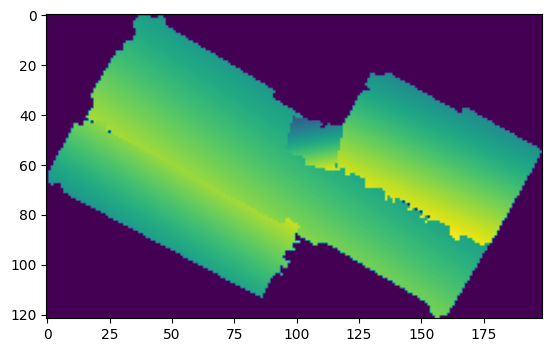

In [523]:
plt.imshow(new_gradient_matrix)

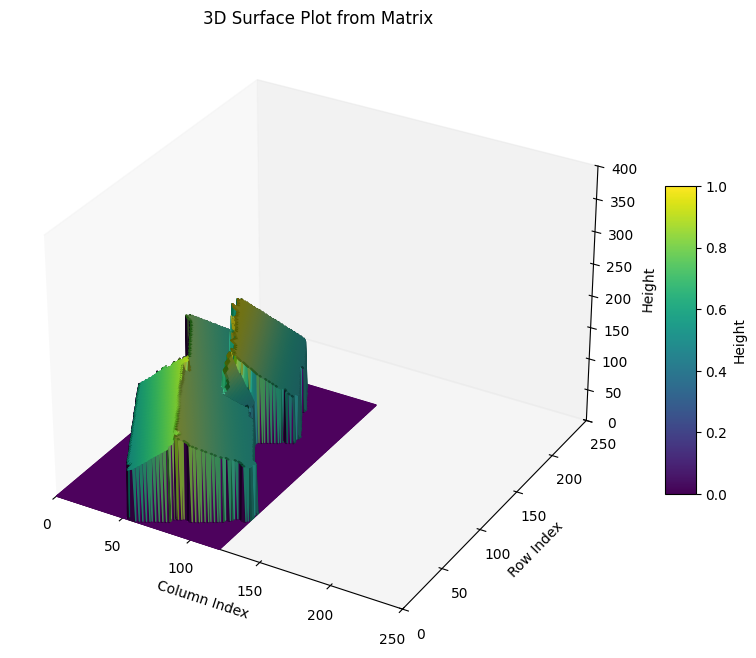

In [524]:
vis_3d_house(np.rot90(new_gradient_matrix, k=3), shape=(250, 250, 400))

## Запуск кода и визуализация кластеризации по высотам и поверхностям

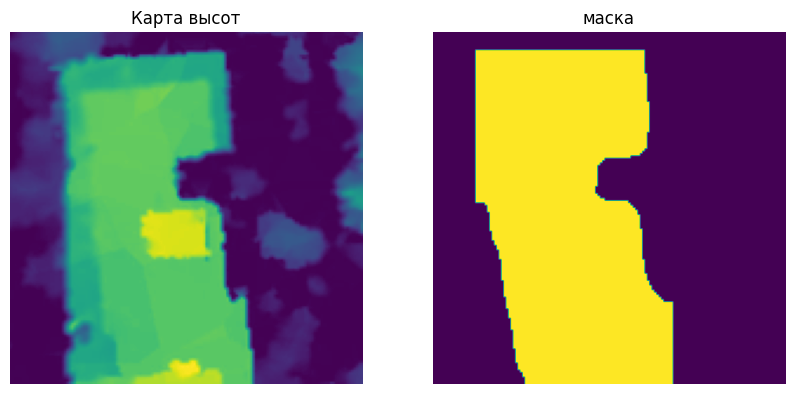

In [89]:
heatmap_resize = np.array(heatmap.resize((576, 1024)))
house_map = heatmap_resize[874:,300:450]
house = np.asarray(result[0].masks.data[7].cpu()[874:,300:450])
vis_heatmap_and_mask(house_map, house)

Высоты кластеров

Есть идея разбить абсолютно все объекты на контуры и проходить по ним дугласом

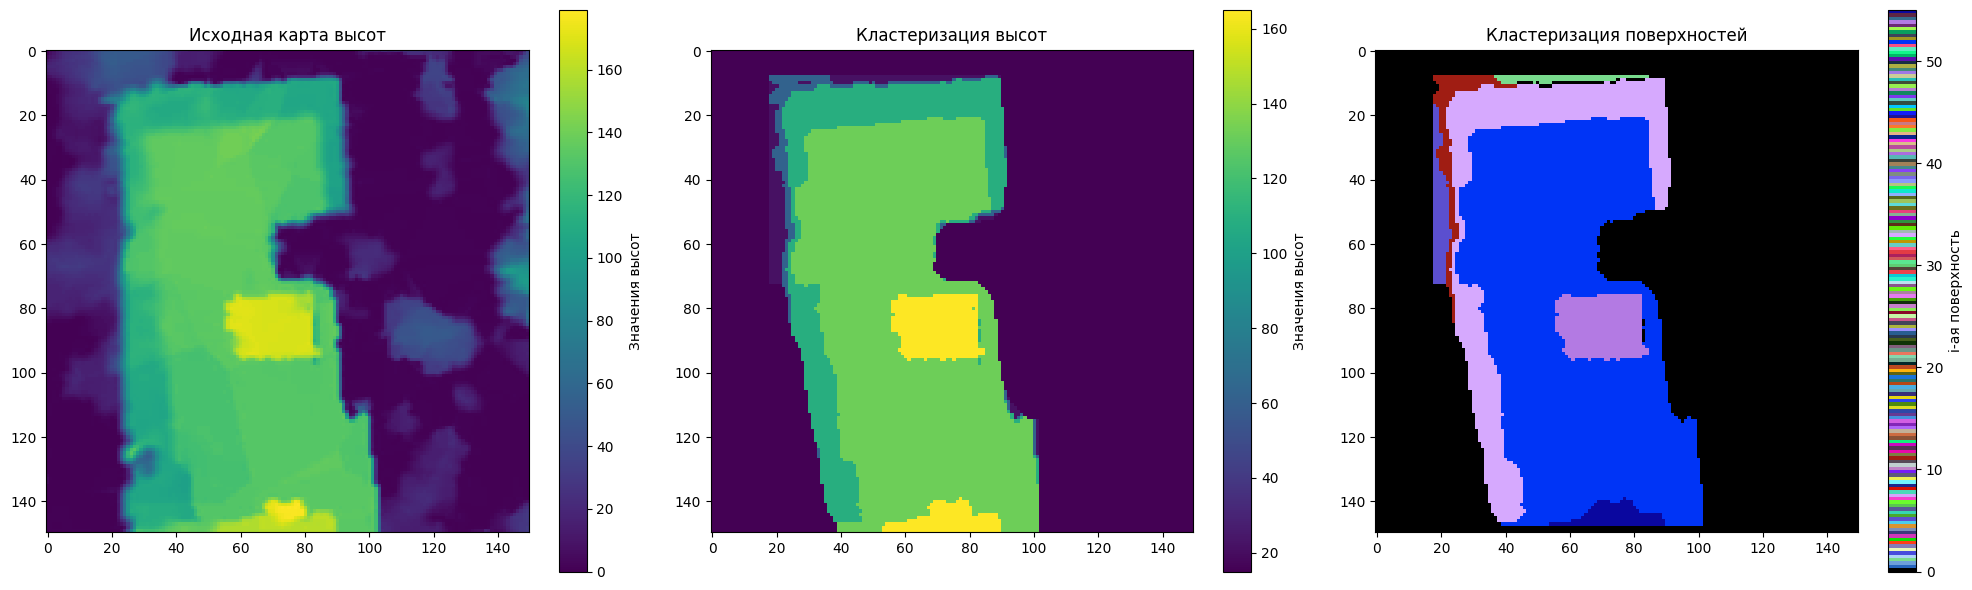

In [6]:
clustered_heights_building = height_clustering(house_map, house)
instance_masks = surface_clustering(clustered_heights_building)
all_masks = concat_masks(instance_masks)
clustered_surfaces_building = smoothed_mask(all_masks, min_size_objects=40, interations=2)
visualisation(house_map, clustered_heights_building, clustered_surfaces_building)
contours_dict = create_polygons(instance_masks, tolerance=1)

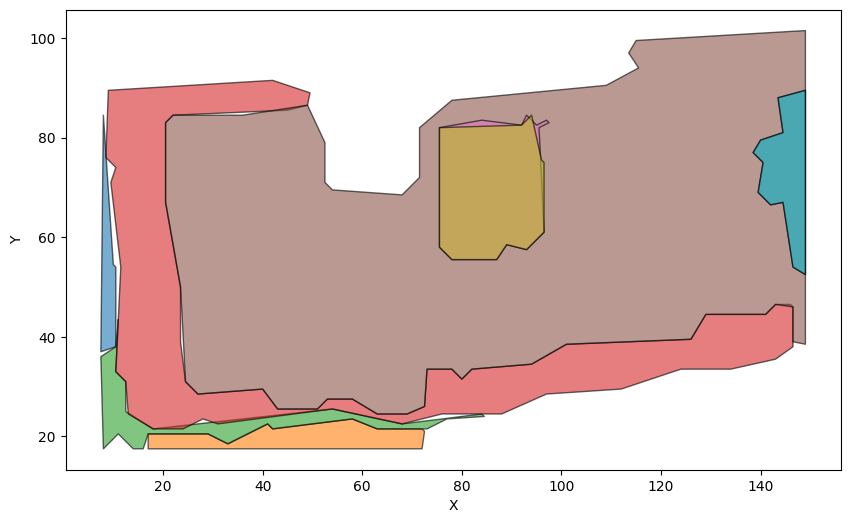

In [7]:
create_approximate_vis(contours_dict)

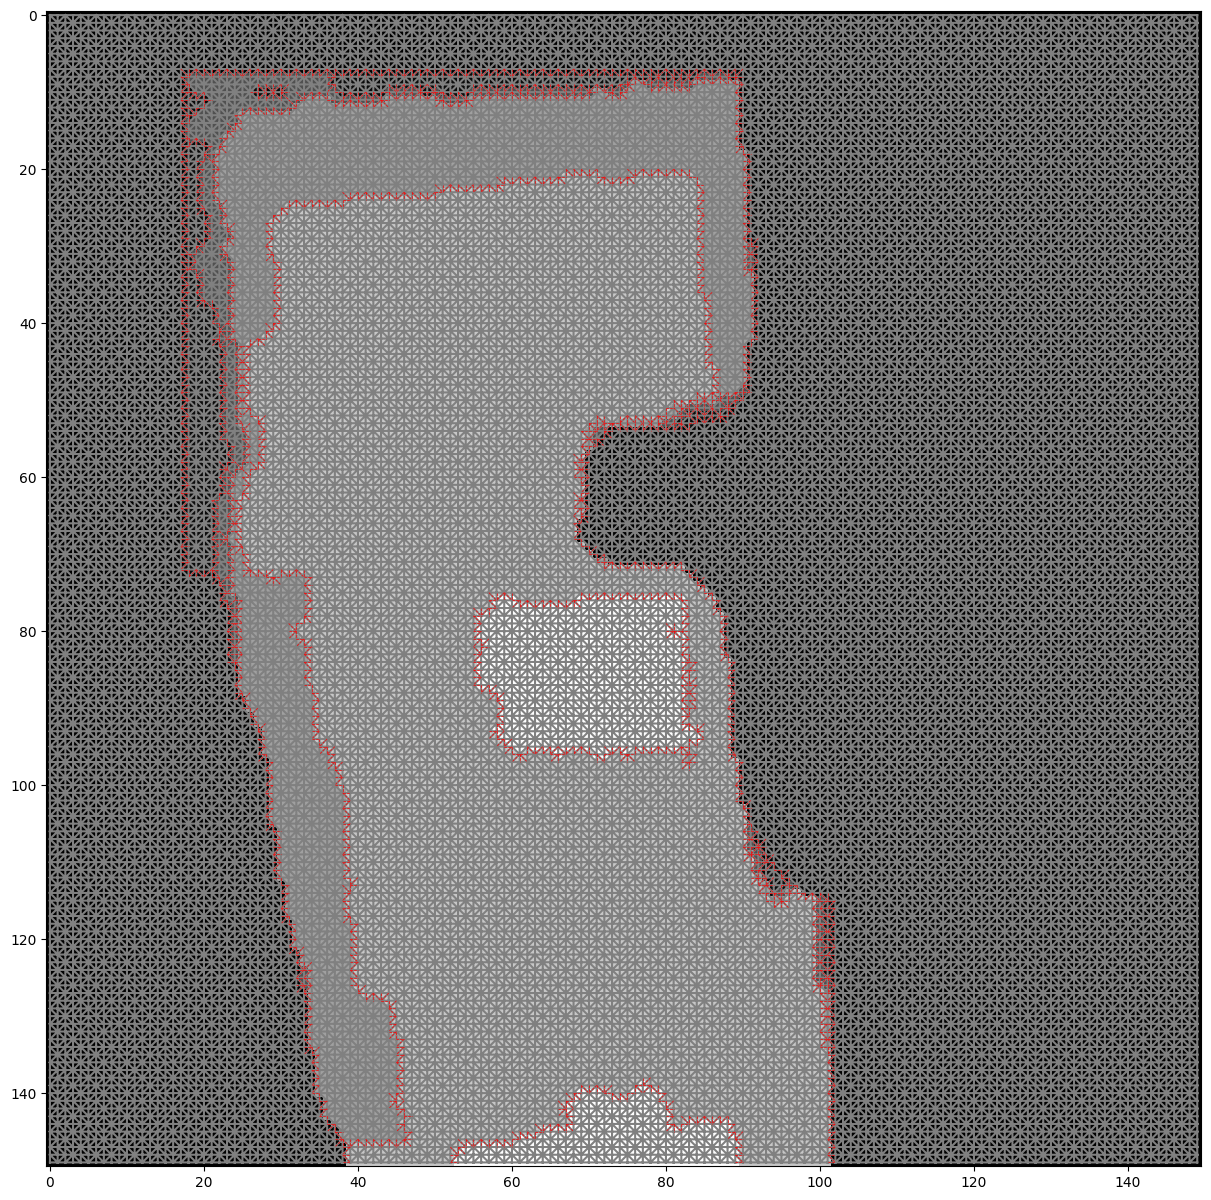

In [8]:
points, triangulation = create_tin(clustered_heights_building)
intersection_lines = extract_intersection_lines(triangulation, clustered_heights_building)
visualisation_lines(points, triangulation, clustered_heights_building, intersection_lines)

###  Алгоритм упрощения и регуляризации для контуров зданий из прямоугольников с неровными краями

Статья: https://www.mdpi.com/2220-9964/12/12/469

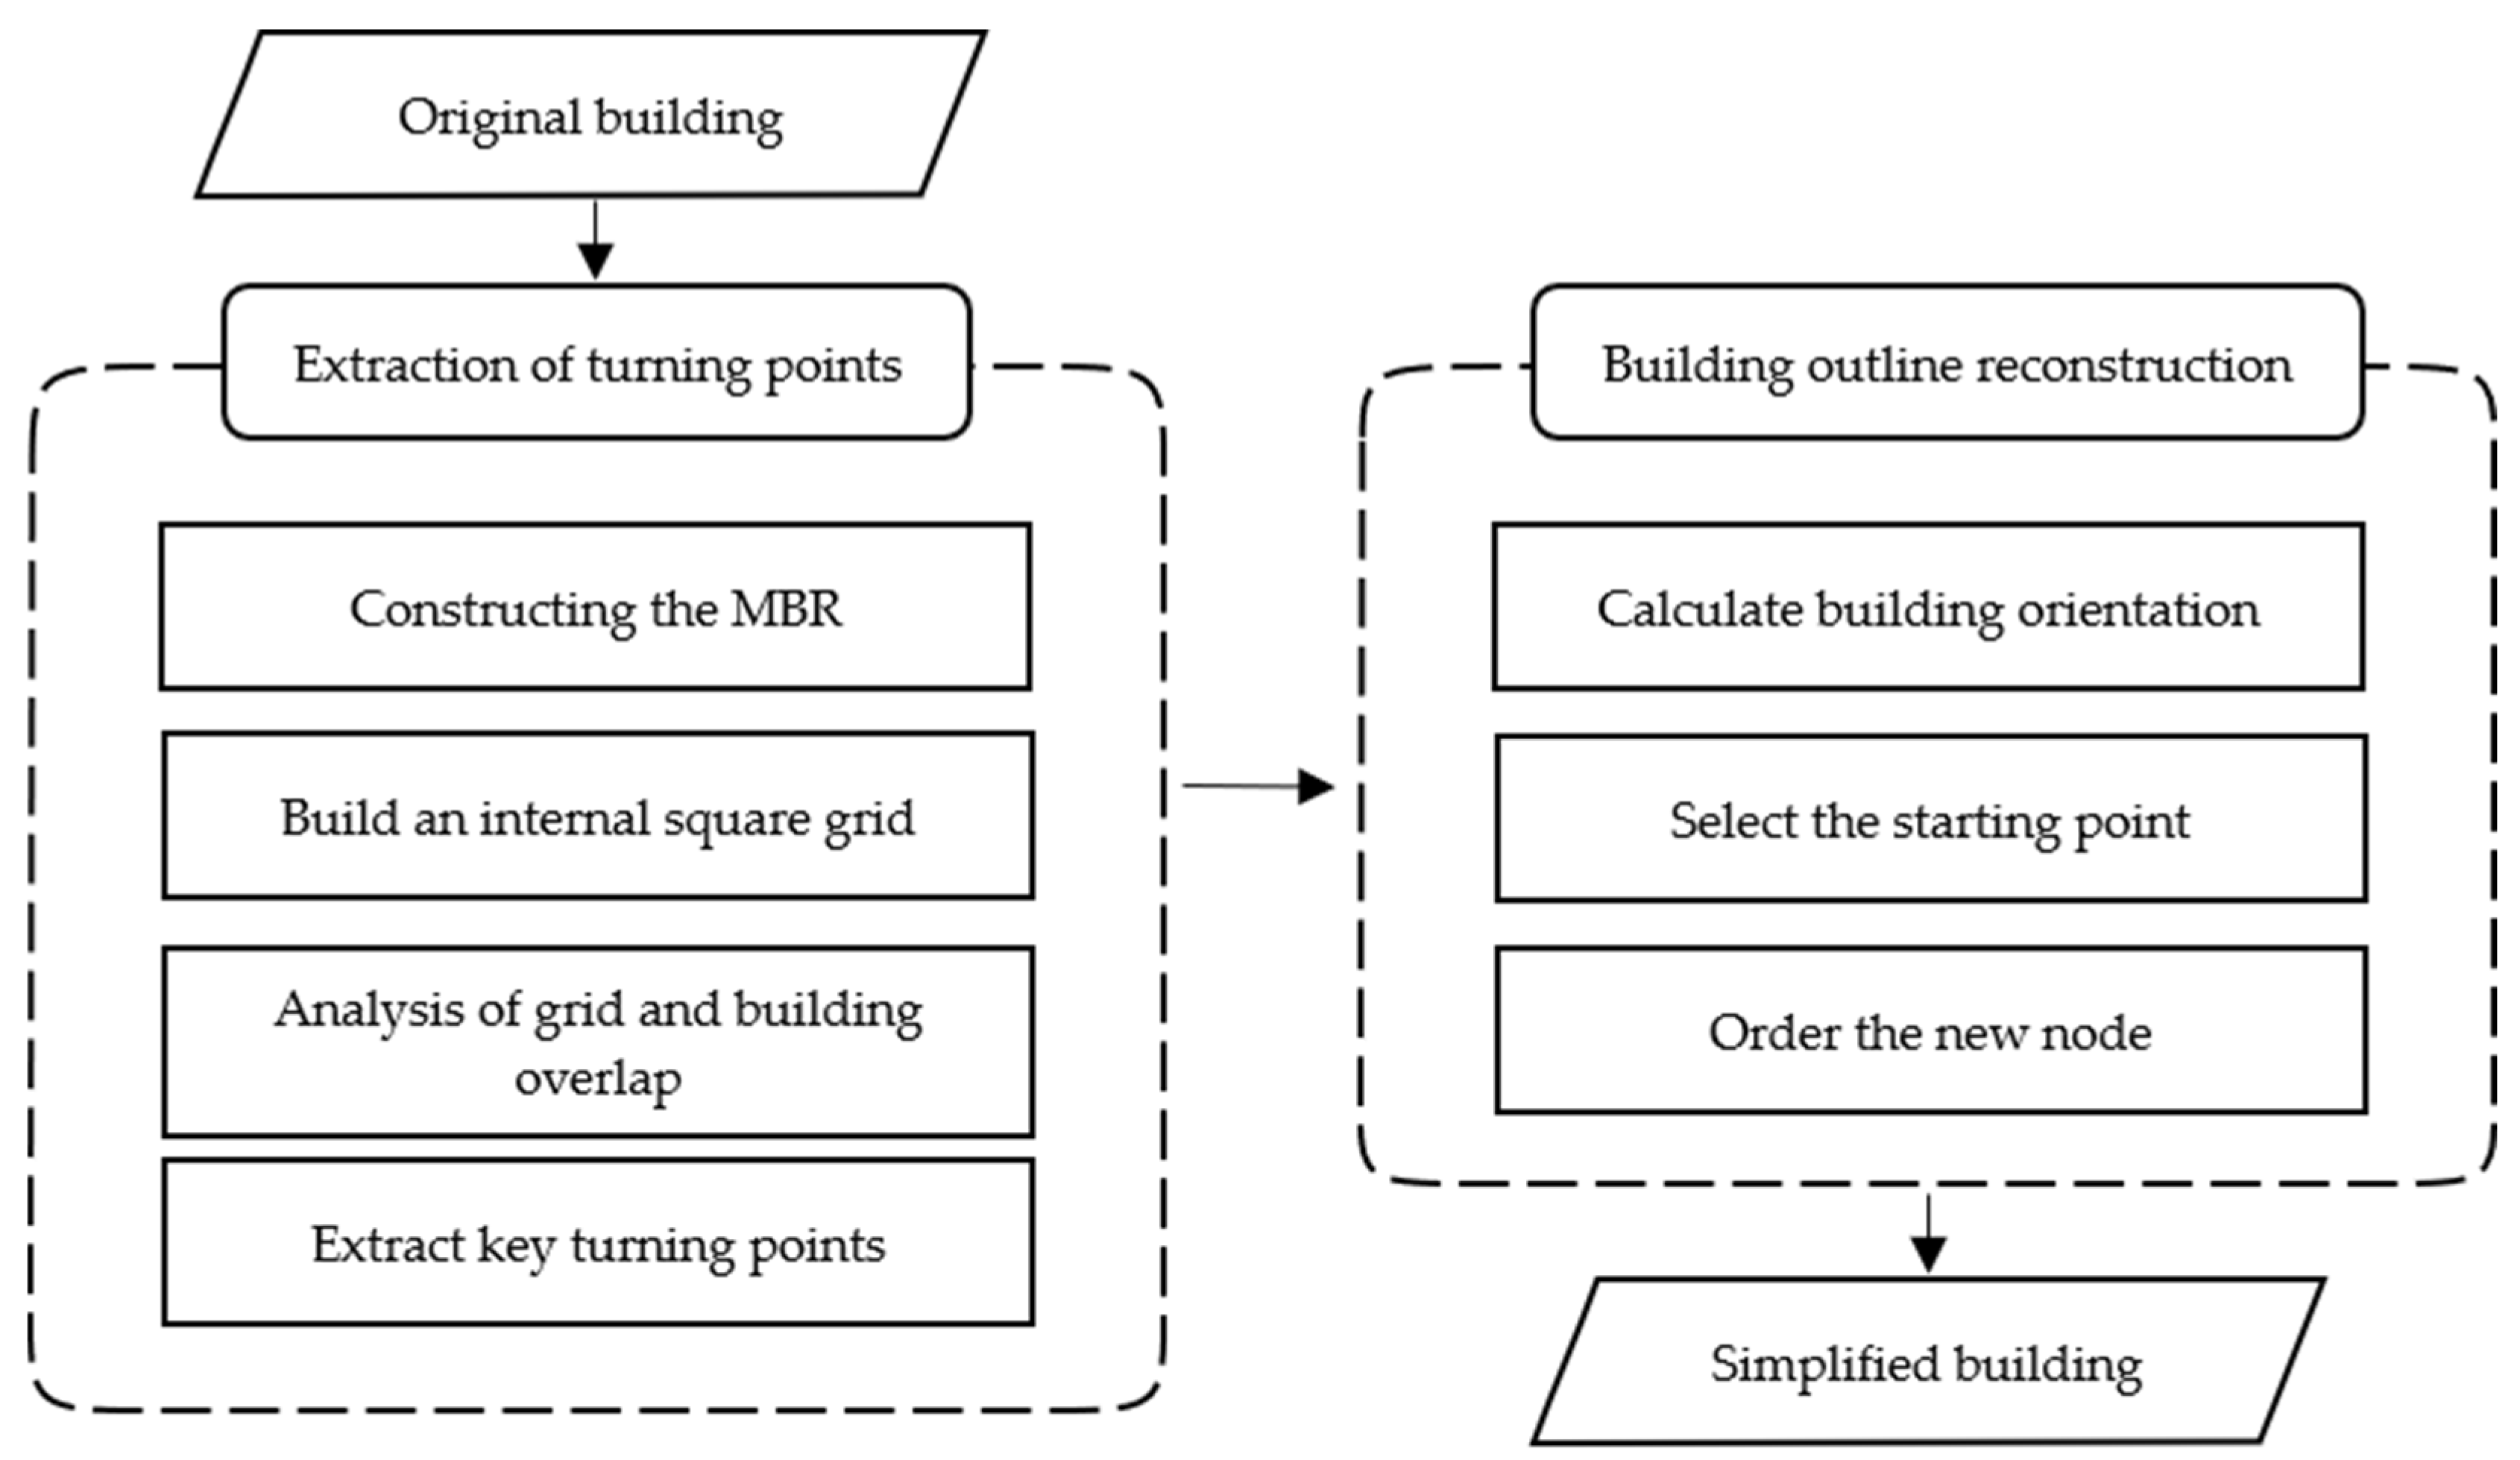

In [9]:
Im('../images/ijgi-12-00469-g002.png', width=1000)

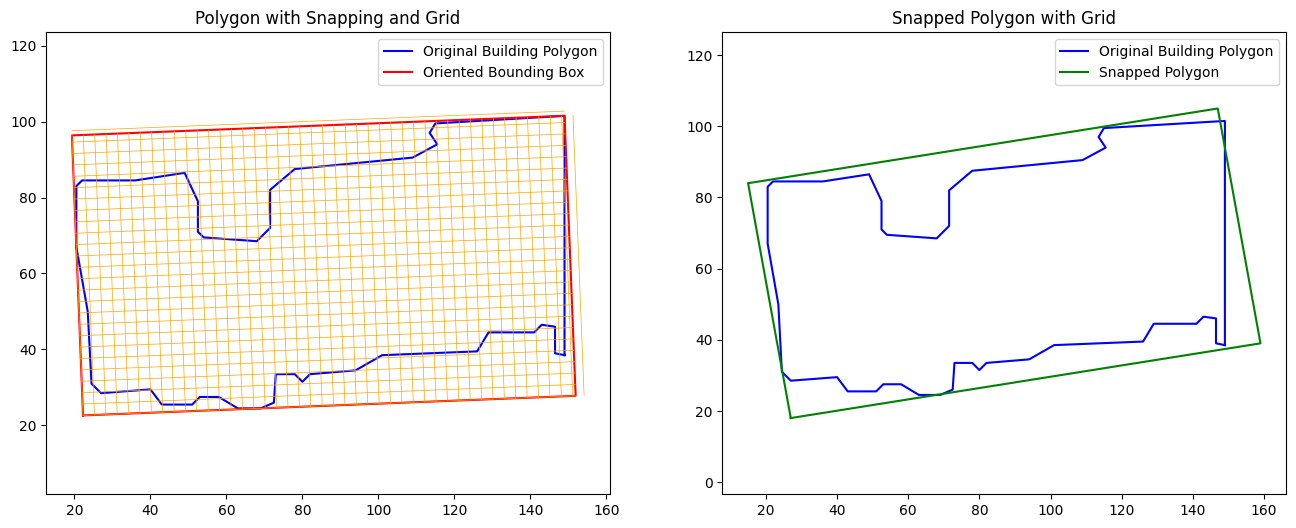

In [10]:
def create_grid_lines(min_point, max_point, rotation_matrix, resolution):
    """
    Создает линии сетки внутри повернутого bounding box.
    
    :param min_point: Минимальные координаты (min_x, min_y) повернутого bounding box
    :param max_point: Максимальные координаты (max_x, max_y) повернутого bounding box
    :param rotation_matrix: Матрица поворота bounding box
    :param resolution: Шаг сетки
    :return: Горизонтальные и вертикальные линии в исходной системе координат
    """
    min_x, min_y = min_point
    max_x, max_y = max_point

    # Горизонтальные линии
    y_coords = np.arange(min_y, max_y + resolution, resolution)
    horizontal_lines = [
        [[min_x, y], [max_x, y]] for y in y_coords
    ]

    # Вертикальные линии
    x_coords = np.arange(min_x, max_x + resolution, resolution)
    vertical_lines = [
        [[x, min_y], [x, max_y]] for x in x_coords
    ]

    # Объединяем линии
    all_lines_rotated = np.array(horizontal_lines + vertical_lines)

    # Обратный поворот линий в исходное пространство
    all_lines_original = []
    for line in all_lines_rotated:
        transformed_line = line @ rotation_matrix
        all_lines_original.append(transformed_line)

    return np.array(all_lines_original)


building_polygon = Polygon(contours_dict[132][0])

# Вычисление bounding box
bbox, rotation_matrix, min_point, max_point = oriented_bounding_box(building_polygon)

# Подравнивание полигона с сеткой
resolution = 3.0  # Разрешение сетки
snapped_polygon, snapped_coords = snap_to_grid(building_polygon, resolution)

# Создание сетки внутри bounding box
grid_lines = create_grid_lines(min_point, max_point, rotation_matrix, resolution)


# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# График 1: Полигоны и сетка
axes[0].plot(*building_polygon.exterior.xy, label="Original Building Polygon", color="blue")
axes[0].plot(bbox[:, 0], bbox[:, 1], label="Oriented Bounding Box", color="red")
for line in grid_lines:
    axes[0].plot(line[:, 0], line[:, 1], color="orange", linewidth=0.5)
axes[0].set_title("Polygon with Snapping and Grid")
axes[0].axis("equal")
axes[0].legend()

# График 2: Полигоны без сетки
axes[1].plot(*building_polygon.exterior.xy, label="Original Building Polygon", color="blue")
axes[1].plot(*snapped_polygon.exterior.xy, label="Snapped Polygon", color="green")

axes[1].set_title("Snapped Polygon with Grid")
axes[1].axis("equal")
axes[1].legend()

plt.show()

Лучше использовать Snapped, основанный на MBR, чем Oriented, основанный на PCA. Он дает более приближенное мажоритарное направление полигона части здания. 
Но также в shapely есть метод minimum_rotated_rectangle, который вроде как делает то же самое

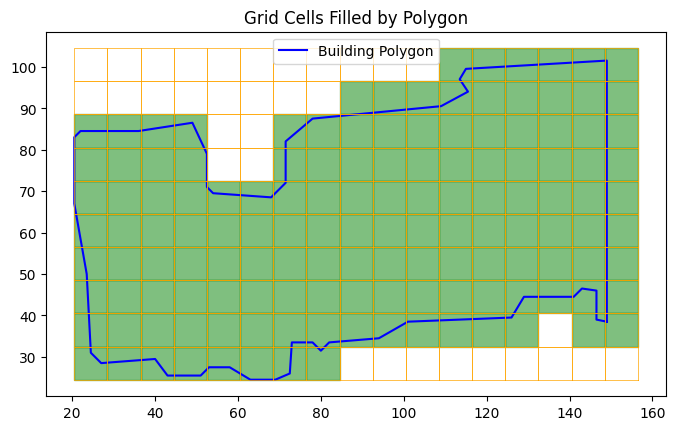

In [ ]:
# Пример использования

# Полигон здания
building_polygon = Polygon(contours_dict[132][0])

# Разрешение сетки
resolution = 8.0  # Размер ячеек

# Создание сетки
grid_cells = create_grid_cells(building_polygon, resolution)

# Заполнение ячеек сетки
filled_cells = fill_grid_cells(building_polygon, grid_cells, resolution)

# Визуализация
fig, ax = plt.subplots(figsize=(8, 6))

# Отображение исходного полигона
x, y = building_polygon.exterior.xy
ax.plot(x, y, label="Building Polygon", color="blue")

# Отображение заполненных ячеек
for cell in filled_cells:
    x, y = cell.exterior.xy
    ax.fill(x, y, color="green", alpha=0.5)
# Отображение всех ячеек сетки
for cell in grid_cells:
    x, y = cell.exterior.xy
    ax.plot(x, y, color="orange", linewidth=0.5)
ax.set_title("Grid Cells Filled by Polygon")
ax.set_aspect("equal")
ax.legend()

plt.show()

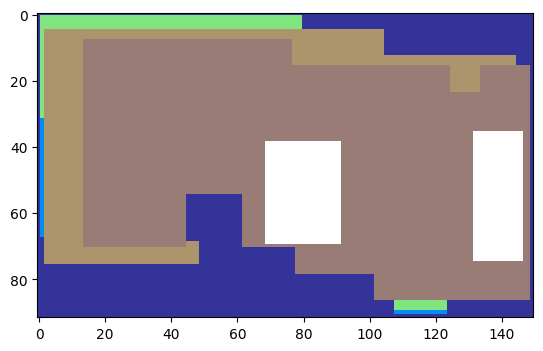

In [12]:
contours_dict_new = convert_to_rectangles(contours_dict, resolution=8.0)
height_map = create_height_map(contours_dict_new, resolution=1)
plt.imshow(height_map, cmap='terrain')


Text(0, 0.5, 'Y')

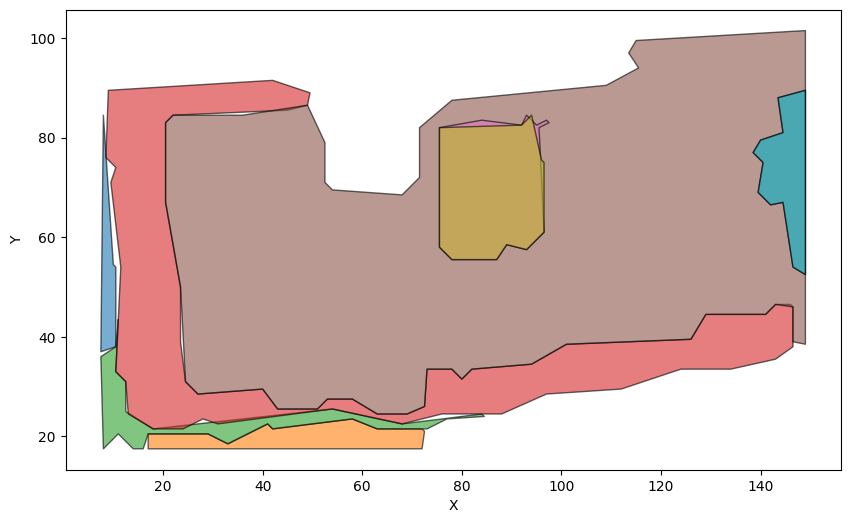

In [13]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as Poly
from matplotlib.collections import PatchCollection
# Создание фигуры и осей
fig, ax = plt.subplots(figsize=(10, 8))

# Цветовая палитра
colors = plt.cm.tab10.colors  # Выбираем палитру
area_threshold: int = 20
# Итерация по словарю
patches = []
for _, polygons in contours_dict.items():
    for polygon in polygons:

        # Проверяем площадь полигона
        if Polygon(polygon).area < area_threshold:
            continue  # Пропускаем слишком маленькие полигоны
        poly_patch = Poly(polygon, closed=True)
        patches.append(poly_patch)

# Добавляем коллекцию полигонов с цветами
collection = PatchCollection(patches, cmap='tab10', edgecolor='black', alpha=0.6)
collection.set_array(np.arange(len(patches)))  # Установка индекса цветов

ax.add_collection(collection)

# Настройка осей
ax.autoscale_view()
ax.set_aspect('equal', adjustable='box')
plt.xlabel('X')
plt.ylabel('Y')

Text(0, 0.5, 'Y')

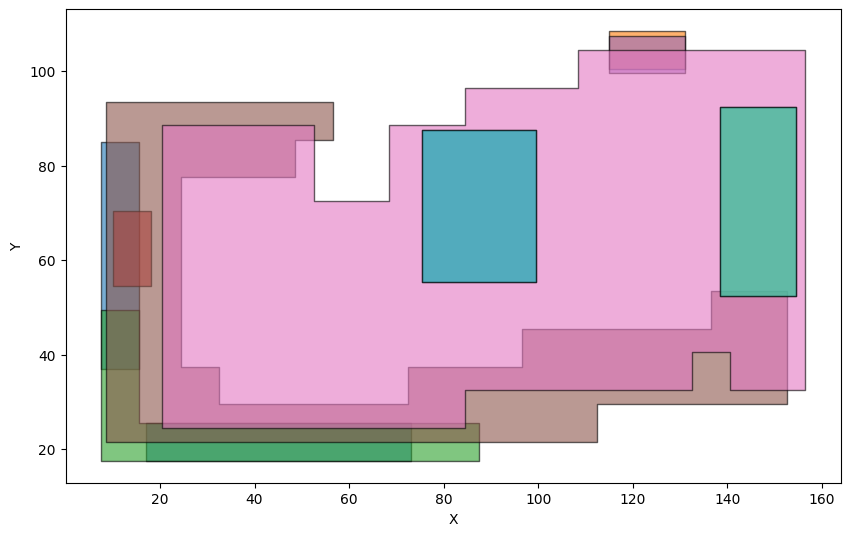

In [14]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as Poly
from matplotlib.collections import PatchCollection
from shapely.geometry import MultiPolygon
# Создание фигуры и осей
fig, ax = plt.subplots(figsize=(10, 8))

# Цветовая палитра
colors = plt.cm.tab10.colors  # Выбираем палитру
area_threshold: int = 100
# Итерация по словарю
patches = []
for _, polygons in contours_dict_new.items():
    for polygon in polygons:
        if polygon.is_empty:
            continue

        # Проверяем площадь полигона
        if polygon.area < area_threshold:
            continue  # Пропускаем слишком маленькие полигоны

        if isinstance(polygon, MultiPolygon):
            for poly in polygon.geoms:
                poly_patch = Poly(list(poly.exterior.coords), closed=True)
        else:
            poly_patch = Poly(list(polygon.exterior.coords), closed=True)

        patches.append(poly_patch)

# Добавляем коллекцию полигонов с цветами
collection = PatchCollection(patches, cmap='tab10', edgecolor='black', alpha=0.6)
collection.set_array(np.arange(len(patches)))  # Установка индекса цветов

ax.add_collection(collection)

# Настройка осей
ax.autoscale_view()
ax.set_aspect('equal', adjustable='box')
plt.xlabel('X')
plt.ylabel('Y')

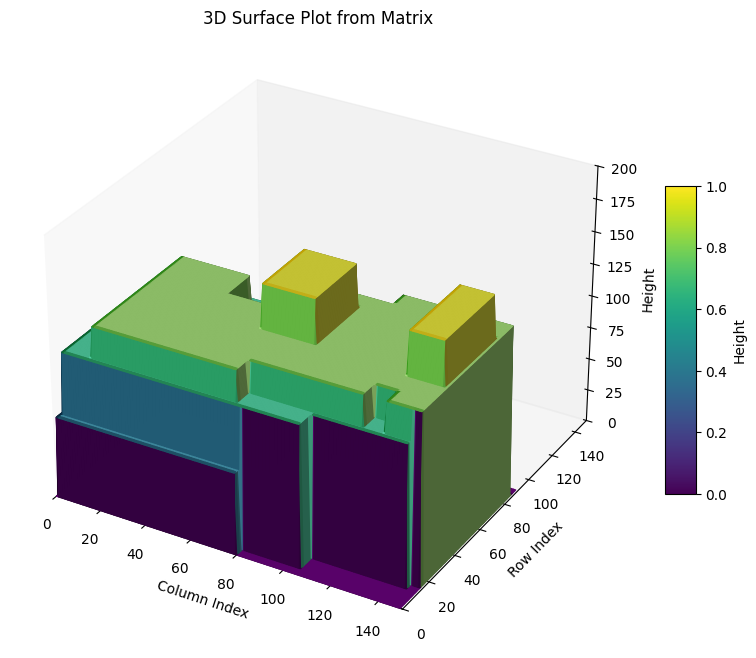

In [15]:
from matplotlib.colors import LightSource
def vis_3d_house(height_map: np.ndarray, shape: Tuple[int] = (150, 150, 200)) -> None:
    rows, cols = height_map.shape

    # Создаем координаты (x, y) для каждой точки
    x, y = np.meshgrid(np.arange(cols), np.arange(rows))
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(projection='3d')
    ls = LightSource(azdeg=100, altdeg=45)
    cmap = plt.cm.viridis
    rgb = ls.shade(height_map, cmap=cmap, blend_mode='soft')
    # Построение поверхности
    surf = ax.plot_surface(x, y, height_map, facecolors=rgb, rstride=1, cstride=1, antialiased=True)

    # Добавление шкалы значений
    cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
    cbar.set_label('Height')

    # Настройка осей
    ax.grid(False)
    ax.set_title("3D Surface Plot from Matrix")
    ax.set_xlabel("Column Index")
    ax.set_ylabel("Row Index")
    ax.set_zlabel("Height")
    ax.set_xlim3d(0, shape[0])
    ax.set_ylim3d(0, shape[1])
    ax.set_zlim3d(0, shape[2])

    plt.show()

vis_3d_house(height_map=height_map)

## Полномасштабная визуализация текущего этапа ресерча

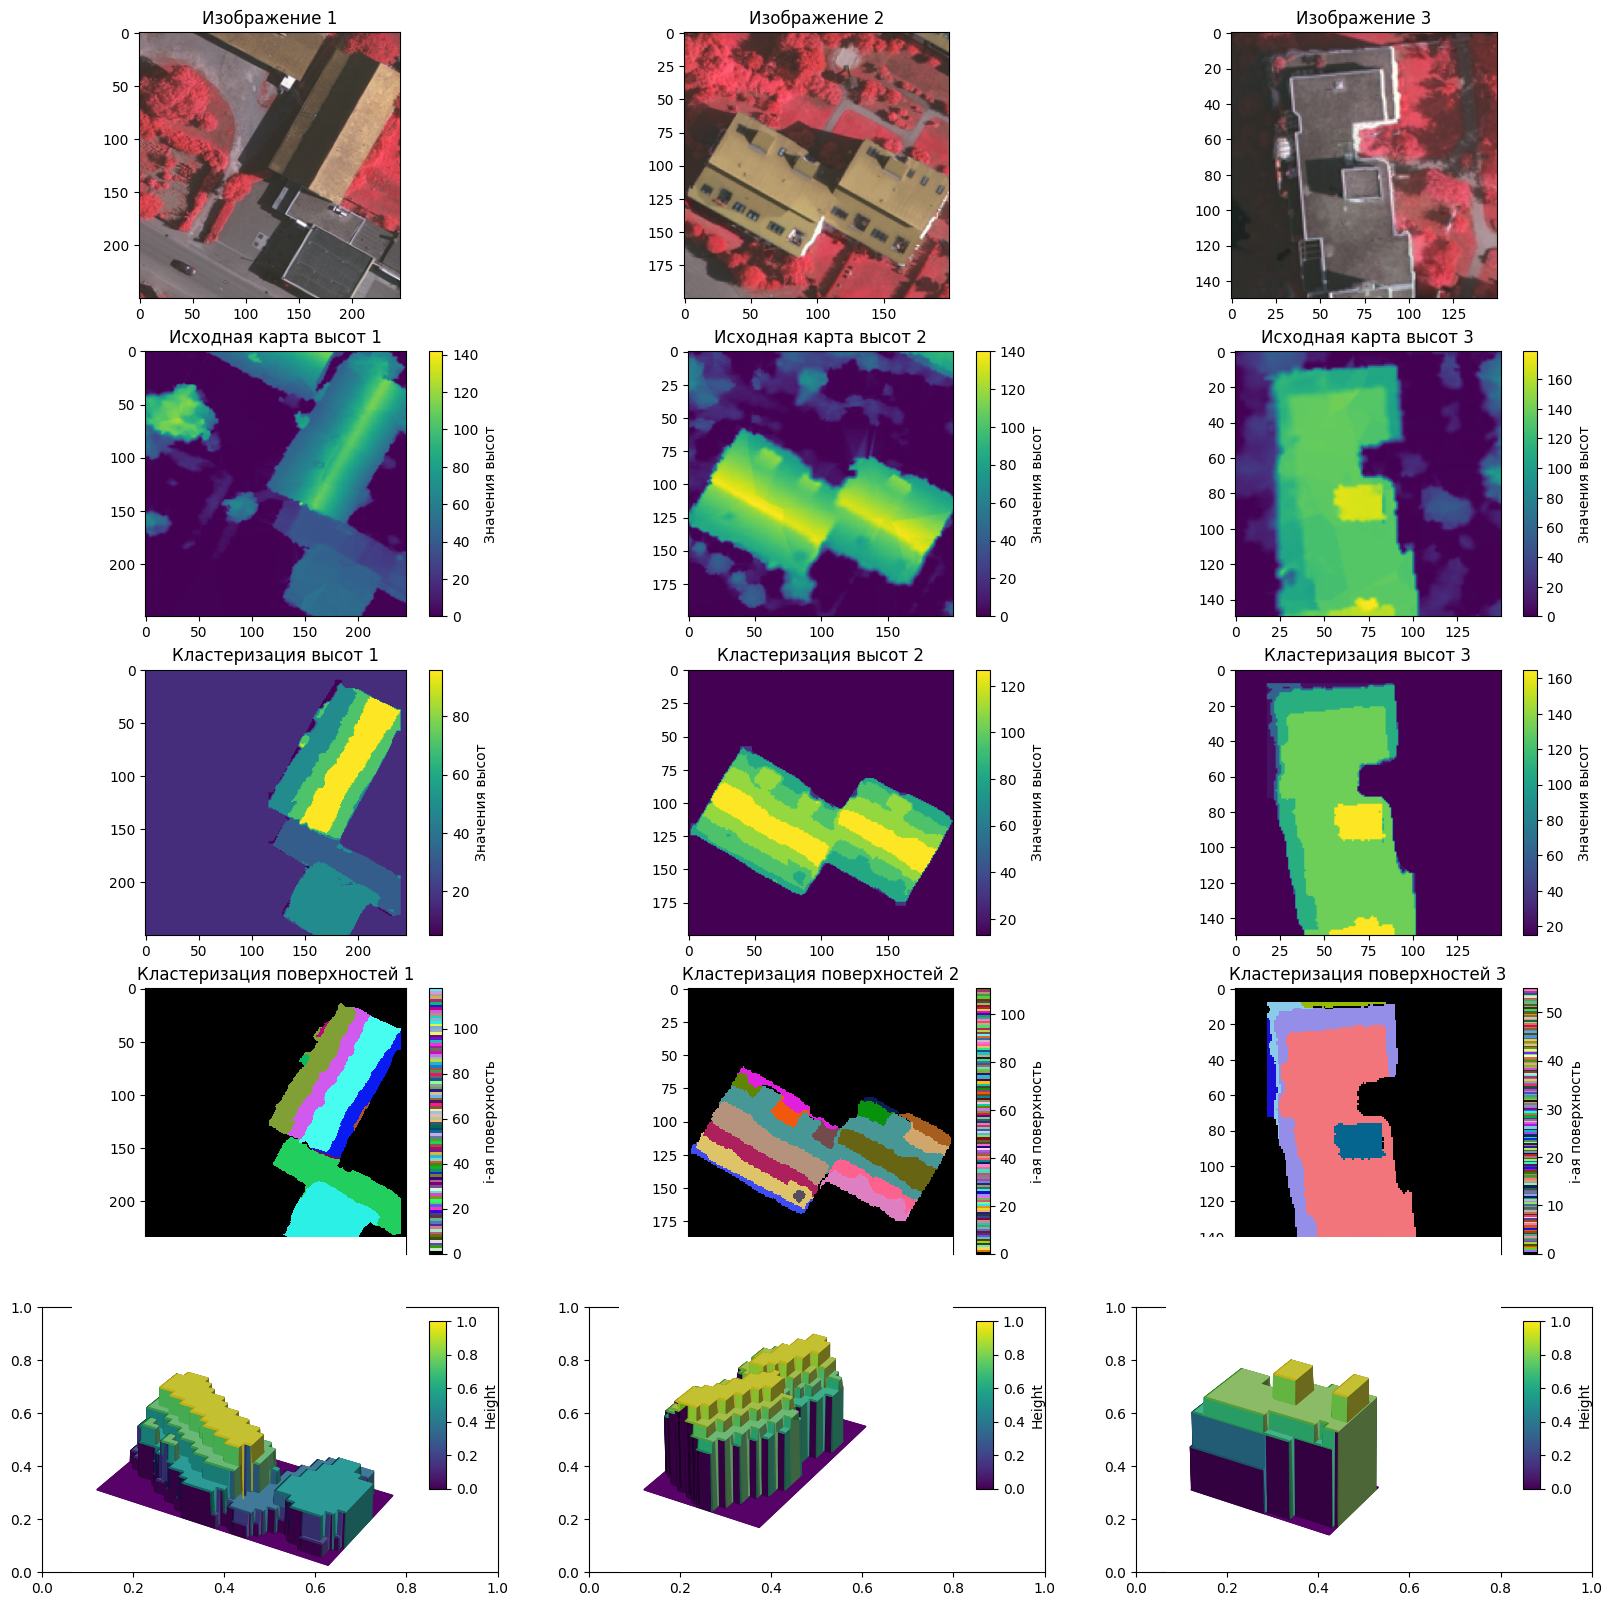

In [6]:
image_resize = image.resize((576, 1024))

crop_image_list = [
    np.array(image_resize)[:250,330:, :],
    np.array(image_resize)[400:600,240:440, :],
    np.array(image_resize)[874:,300:450, :],
]
instance_mask_list = [
    np.asarray(result[0].masks.data[10].cpu()[:250,330:]),
    np.asarray(result[0].masks.data[0].cpu()[400:600,240:440]),
    np.asarray(result[0].masks.data[7].cpu()[874:,300:450]),
]
house_map_list = [
    np.array(heatmap)[:250,330:],
    np.array(heatmap)[400:600,240:440],
    np.array(heatmap)[874:,300:450]
]
all_visualisation(
    crop_image_list=crop_image_list,
    house_map_list=house_map_list,
    instance_mask_list=instance_mask_list,

)

## Старые визуализации сцен

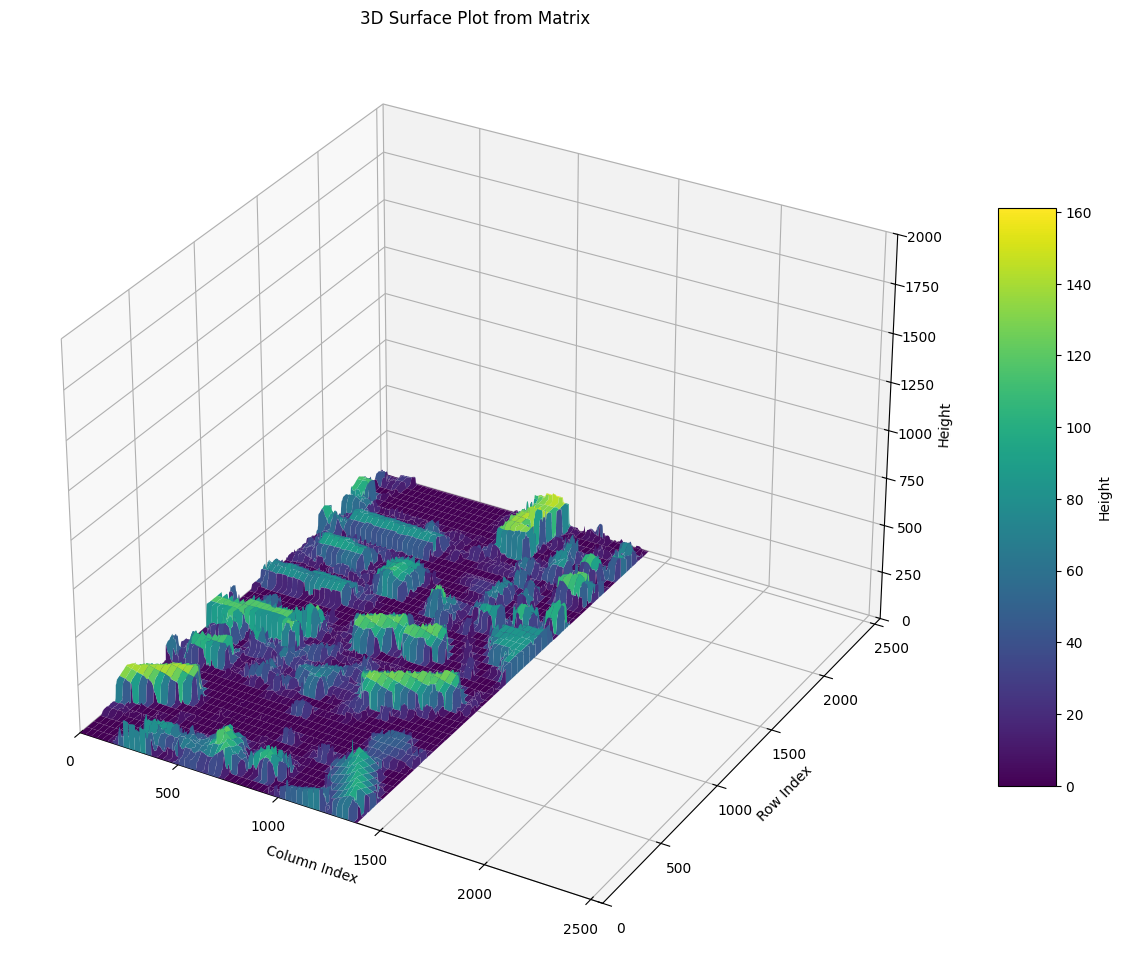

In [6]:
from matplotlib.colors import LogNorm
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(projection='3d')

# Построение поверхности
surf = ax.plot_surface(X, Y, np.array(image), cmap='viridis', edgecolor='none')

# Добавление шкалы значений
cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Height')

# Настройка осей
ax.set_title("3D Surface Plot from Matrix")
ax.set_xlabel("Column Index")
ax.set_ylabel("Row Index")
ax.set_zlabel("Height")
ax.set_xlim3d(0, 2555)
ax.set_ylim3d(0, 2555)
ax.set_zlim3d(0, 2000)

plt.show()

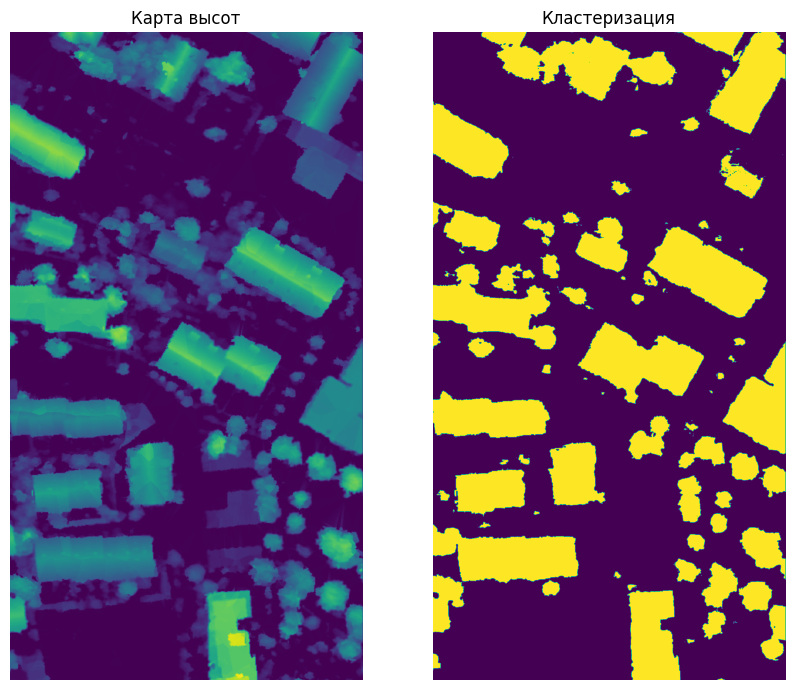

In [7]:
height_map = np.array(Image.open(vai))
pixels = height_map.reshape(-1, 1)
kmeans = KMeans(n_clusters=2, random_state=0)  # Можно выбрать любое количество кластеров
kmeans.fit(pixels)

# Шаг 4: Преобразуем метки кластеров обратно в двумерное изображение
segmented_image = kmeans.labels_.reshape(height_map.shape)

fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(height_map)
axes[0].set(title='Карта высот')
axes[0].axis('off')
axes[1].imshow(segmented_image)
axes[1].set(title='Кластеризация');
axes[1].axis('off');

In [8]:
masked_height_map = height_map * segmented_image

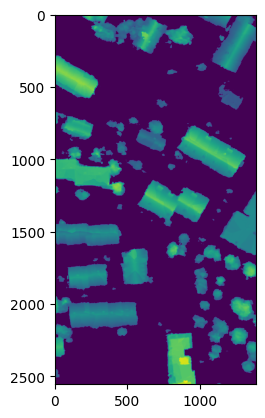

In [9]:
plt.imshow(masked_height_map)

In [10]:
coordinates = np.array(np.where(segmented_image == 1)).T
height_values = masked_height_map[segmented_image == 1]

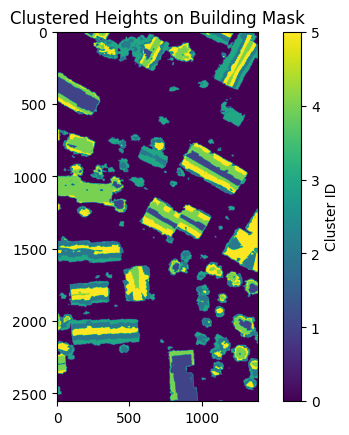

In [ ]:
coordinates = np.array(np.where(segmented_image == 1)).T
height_values = masked_height_map[segmented_image == 1]
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(height_values.reshape(-1, 1))
np.array([
    [1, 1, 1, 0, 0],
    [1, 1, 1, 0, 0],
    [1, 1, 1, 2, 2],
    [0, 0, 2, 2, 2],
    [0, 0, 2, 2, 2]
])
# Получаем метки кластеров для каждой точки
labels = kmeans.labels_

# Визуализируем результаты кластеризации на маске зданий
clustered_height_map = np.zeros_like(height_map)

# Помещаем значения кластеров обратно в картину (на маску зданий)
clustered_height_map[segmented_image == 1] = labels + 1  # Придаем каждому кластеру уникальный номер

# Визуализируем результат
plt.imshow(clustered_height_map, cmap='viridis')
plt.colorbar(label="Cluster ID")
plt.title("Clustered Heights on Building Mask")
plt.show()